# Análise Não Supervisionada em Reclamações

## Introdução

Este notebook utiliza técnicas de aprendizado não supervisionado para explorar o dataset de reclamações. O objetivo é extrair informações úteis, como agrupamentos de reclamações e padrões associados a sentimentos, categorias e emoções.

As etapas envolvem:
1. Gerar embeddings das reclamações usando **BERT**.
2. Aplicar técnicas de clusterização para identificar grupos naturais.
3. Usar redução de dimensionalidade para visualizar os agrupamentos.
4. Relacionar os clusters identificados com sentimentos e categorias.

---

## Etapas do Processo

### 1. Carregar e Explorar o Dataset


In [55]:
# Importar bibliotecas necessárias
import pandas as pd

# Carregar o dataset
file_path = 'reclamações.csv'  # Substitua pelo caminho correto
reclamacoes_df = pd.read_csv(file_path)

# Explorar o dataset
print("Dimensões do dataset:", reclamacoes_df.shape)
print("Colunas disponíveis:", reclamacoes_df.columns)
print(reclamacoes_df.head())

Dimensões do dataset: (303, 16)
Colunas disponíveis: Index(['id', 'nome_reclamante', 'email_reclamante', 'telefone_reclamante',
       'tipo_reclamacao', 'sentimento', 'emocao', 'cidade', 'rua', 'bairro',
       'estado', 'data_submissao', 'data_resposta', 'categoria', 'descricao',
       'emocao.1'],
      dtype='object')
   id nome_reclamante         email_reclamante telefone_reclamante  \
0   1    Maria Santos   maria.santos@email.com     (84) 99876-5432   
1   2   João Oliveira  joao.oliveira@email.com     (84) 98765-4321   
2   3    Carla Farias   carla.farias@email.com     (84) 98888-7777   
3   4   Pedro Alencar  pedro.alencar@email.com     (84) 99999-6666   
4   5        Ana Lima       ana.lima@email.com     (84) 98765-1234   

  tipo_reclamacao sentimento        emocao      cidade  \
0      Reclamação   negative   frustration       Natal   
1         Demanda    neutral  indifference  Parnamirim   
2        Sugestão   positive          hope       Natal   
3      Reclamação   ne

### 2. Preparação e Limpeza dos Dados
- O texto da reclamação está na coluna descricao.
- Removemos registros onde o texto está ausente para evitar problemas no processamento.



In [56]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(reclamacoes_df.isnull().sum())

# Selecionar apenas as colunas relevantes
dados_selecionados = reclamacoes_df[['descricao', 'sentimento', 'categoria', 'emocao']]

# Remover linhas com descrição ausente
dados_limpos = dados_selecionados.dropna(subset=['descricao'])

print("Dimensões após limpeza:", dados_limpos.shape)


Valores ausentes por coluna:
id                       0
nome_reclamante          0
email_reclamante         0
telefone_reclamante      0
tipo_reclamacao          5
sentimento               0
emocao                 187
cidade                   0
rua                      0
bairro                   0
estado                   0
data_submissao           0
data_resposta           25
categoria                0
descricao              203
emocao.1               116
dtype: int64
Dimensões após limpeza: (100, 4)


### 3. Gerar Embeddings com BERT

In [57]:
# Importar bibliotecas necessárias para NLP
from transformers import AutoTokenizer, AutoModel
import torch

# Carregar modelo e tokenizer BERT em português
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Função para gerar embeddings de texto
def gerar_embeddings(textos):
    inputs = tokenizer(textos, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Usar média das representações
    return embeddings.numpy()

# Gerar embeddings para as descrições
textos = dados_limpos['descricao'].tolist()
embeddings = gerar_embeddings(textos)

print("Formato dos embeddings:", embeddings.shape)


Formato dos embeddings: (100, 768)


### Visualização do embedding

In [15]:
# Selecionar uma reclamação e seu embedding correspondente
indice = 0  # Escolha um índice (por exemplo, 0 para a primeira reclamação)
texto_selecionado = textos[indice]
embedding_selecionado = embeddings[indice]

# Mostrar o texto e seu embedding
print(f"Texto da Reclamação: {texto_selecionado}")
print(f"Embedding ({len(embedding_selecionado)} dimensões):\n{embedding_selecionado}")


Texto da Reclamação: A rua está muito escura há semanas, com postes de luz apagados, o que aumenta o risco de assaltos.
Embedding (768 dimensões):
[-2.08562464e-01 -2.33874500e-01  3.66255999e-01 -1.96725994e-01
  3.82304162e-01 -1.23102166e-01 -3.00064951e-01 -4.64097485e-02
  2.58142948e-01 -2.14916587e-01  1.86653763e-01  6.28211677e-01
 -2.54730880e-01  1.60977259e-01 -7.69883692e-02  8.63630474e-02
  3.65477264e-01  2.79065315e-02  1.56227052e-01 -2.02342376e-01
 -1.18428759e-01  1.76315345e-02  2.88231373e-01 -1.34151310e-01
 -3.54755193e-01  2.23076299e-01 -3.36510316e-02  7.84728155e-02
 -3.16615462e-01 -5.97728670e-01  1.97330624e-01  7.85159692e-02
 -1.44030988e-01  1.70250863e-01  2.65048355e-01 -1.12153493e-01
  4.63498384e-02  5.78788221e-02  9.71295089e-02  1.99780092e-01
 -5.95101602e-02  3.09311599e-02 -1.45974800e-01 -1.91153273e-01
  1.88496202e-01 -1.45487785e-01  1.06615044e-01 -2.30329558e-01
 -2.35940263e-01  2.00154688e-02  7.10564405e-02  5.64821018e-03
 -5.5569

### Foi adicionado uma etapa de pré processamento para corrigir o problema das classes de emoção.
- As emoções estavam definidas parte em portugues e parte em inglês, com algumas classes sendo ambiguas, mas em idiomas diferentes. 

In [61]:
print(dados_limpos['emocao'].unique())


['frustration' 'indifference' 'hope' 'anger' 'annoyance' 'enthusiasm'
 'neutrality' 'concern' 'fear' 'despair' 'sadness' 'disgust'
 'helplessness' 'anxiety' 'disappointment' 'suffering' 'worry' 'medo'
 'raiva' 'insegurança' 'preocupação' 'desespero' 'frustração' 'indignação'
 'vulnerabilidade' 'impotência' 'ansiedade' 'desconfiança' 'revolta'
 'tristeza' 'apreensão']


In [63]:
# Dicionário de mapeamento (padronizando para português)
# Aplicado um dicionário para mapear as emoções de maneira correta, padronizando as classes.

emocao_mapping = {
    'frustration': 'frustração',
    'indifference': 'indiferença',
    'hope': 'esperança',
    'anger': 'raiva',
    'annoyance': 'irritação',
    'enthusiasm': 'entusiasmo',
    'neutrality': 'neutralidade',
    'concern': 'preocupação',
    'fear': 'medo',
    'despair': 'desespero',
    'sadness': 'tristeza',
    'disgust': 'repulsa',
    'helplessness': 'impotência',
    'anxiety': 'ansiedade',
    'disappointment': 'decepção',
    'suffering': 'sofrimento',
    'worry': 'preocupação',
    'medo': 'medo',
    'raiva': 'raiva',
    'insegurança': 'insegurança',
    'preocupação': 'preocupação',
    'desespero': 'desespero',
    'frustração': 'frustração',
    'indignação': 'indignação',
    'vulnerabilidade': 'vulnerabilidade',
    'impotência': 'impotência',
    'ansiedade': 'ansiedade',
    'desconfiança': 'desconfiança',
    'revolta': 'revolta',
    'tristeza': 'tristeza',
    'apreensão': 'apreensão'
}

In [64]:
# Verificar os valores únicos antes da padronização
print("Valores únicos antes da padronização:")
print(dados_limpos['emocao'].unique())

# Aplicar o mapeamento para padronizar as emoções
dados_limpos['emocao'] = dados_limpos['emocao'].map(emocao_mapping)

# Verificar os valores únicos após a padronização
print("Valores únicos após a padronização:")
print(dados_limpos['emocao'].unique())


Valores únicos antes da padronização:
['frustration' 'indifference' 'hope' 'anger' 'annoyance' 'enthusiasm'
 'neutrality' 'concern' 'fear' 'despair' 'sadness' 'disgust'
 'helplessness' 'anxiety' 'disappointment' 'suffering' 'worry' 'medo'
 'raiva' 'insegurança' 'preocupação' 'desespero' 'frustração' 'indignação'
 'vulnerabilidade' 'impotência' 'ansiedade' 'desconfiança' 'revolta'
 'tristeza' 'apreensão']
Valores únicos após a padronização:
['frustração' 'indiferença' 'esperança' 'raiva' 'irritação' 'entusiasmo'
 'neutralidade' 'preocupação' 'medo' 'desespero' 'tristeza' 'repulsa'
 'impotência' 'ansiedade' 'decepção' 'sofrimento' 'insegurança'
 'indignação' 'vulnerabilidade' 'desconfiança' 'revolta' 'apreensão']


### 4. Aplicar Clusterização com K-Means

sentimento         negative  neutral  positive
sentiment_cluster                             
0                        37        0         0
1                        44        9         0
2                         0        0        10


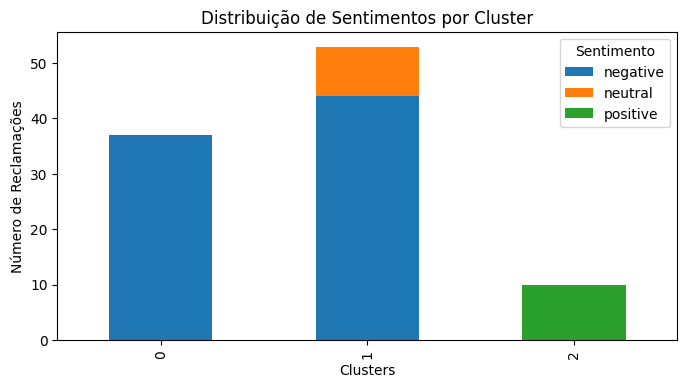

In [69]:
from sklearn.cluster import KMeans

# Aplicar K-Means para agrupar sentimentos
n_clusters = 3  # Presumindo 3 grupos: positivo, neutro, negativo
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)  # Explicitando n_init
dados_limpos.loc[:, 'sentiment_cluster'] = kmeans.fit_predict(embeddings)  # adicionando uma coluna de clusters no dataset (com os clusters definidos pelo kmeans)

# Relacionar clusters com sentimentos
sentiment_distribution = dados_limpos.groupby(['sentiment_cluster', 'sentimento']).size().unstack(fill_value=0)
print(sentiment_distribution)

# Visualizar em gráfico
sentiment_distribution.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title("Distribuição de Sentimentos por Cluster")
plt.ylabel("Número de Reclamações")
plt.xlabel("Clusters")
plt.legend(title="Sentimento")
plt.show()


In [ ]:
Cluster 1: 53 reclamações

Este cluster contém o maior número de reclamações (53).
Representa o maior grupo de reclamações que possuem características semelhantes com base no embedding do texto.
Cluster 0: 37 reclamações

Este é o segundo maior grupo com 37 reclamações.
Os textos desse cluster são mais parecidos entre si do que com os clusters 1 ou 2.
Cluster 2: 10 reclamações

Este cluster tem o menor número de reclamações (10).
Pode indicar um grupo muito específico ou outliers (reclamações menos comuns).

### 5. Redução de Dimensionalidade para Visualização

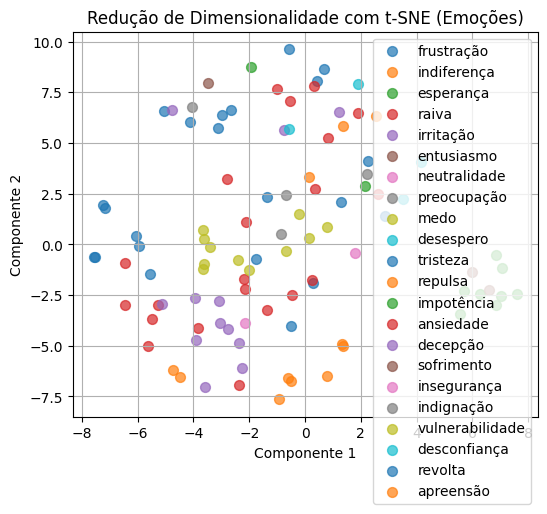

In [73]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduzir dimensionalidade com t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)  # Configurações ajustadas
embeddings_2d = tsne.fit_transform(embeddings)

# Adicionar as coordenadas reduzidas ao DataFrame
dados_limpos.loc[:, 'tsne_x'] = embeddings_2d[:, 0]
dados_limpos.loc[:, 'tsne_y'] = embeddings_2d[:, 1]

# Visualizar emoções em 2D com t-SNE
plt.figure(figsize=(6, 5))
for emocao in dados_limpos['emocao'].unique():
    subset = dados_limpos[dados_limpos['emocao'] == emocao]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], label=emocao, alpha=0.7, s=50)
plt.legend()
plt.title("Redução de Dimensionalidade com t-SNE (Emoções)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid()
plt.show()






### 6. Relacionar Clusters com Sentimentos



sentimento         negative  neutral  positive
sentiment_cluster                             
0                        37        0         0
1                        44        9         0
2                         0        0        10


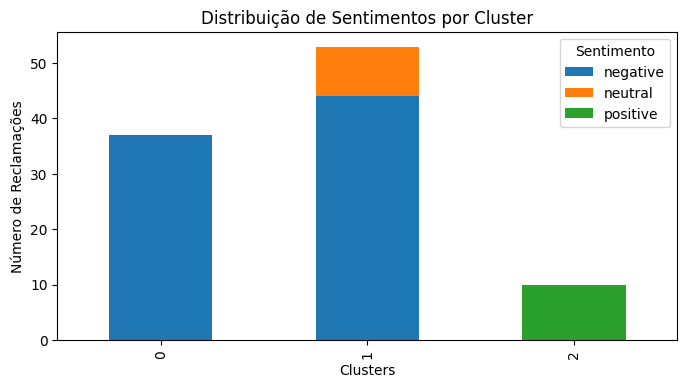

In [71]:
# Relacionar clusters com sentimentos
cluster_sentimentos = dados_limpos.groupby(['sentiment_cluster', 'sentimento']).size().unstack(fill_value=0)
print(cluster_sentimentos)

# Visualizar a relação em gráfico de barras
cluster_sentimentos.plot(kind='bar', stacked=True, figsize=(8, 4))
plt.title("Distribuição de Sentimentos por Cluster")
plt.ylabel("Número de Reclamações")
plt.xlabel("Clusters")
plt.legend(title="Sentimento")
plt.show()



Clusters identificados pelo DBSCAN:
dbscan_cluster
-1    100
Name: count, dtype: int64
sentimento      negative  neutral  positive
dbscan_cluster                             
-1                    81        9        10


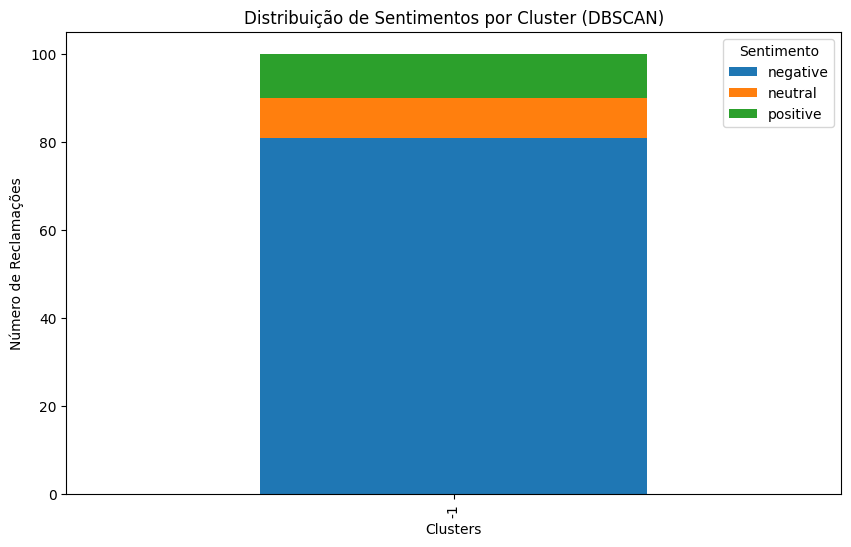

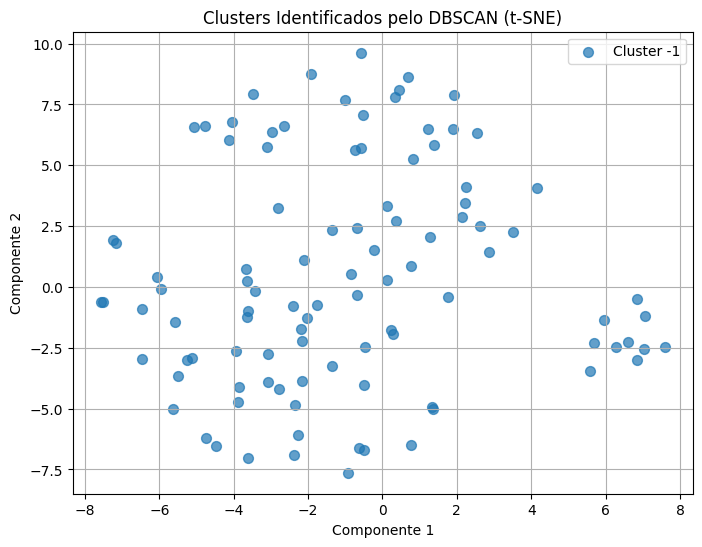

In [75]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Padronizar os embeddings (escala uniforme é importante para DBSCAN)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Aplicar DBSCAN
#dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste eps e min_samples conforme necessário
dbscan = DBSCAN(eps=1.0, min_samples=5)

dados_limpos['dbscan_cluster'] = dbscan.fit_predict(embeddings_scaled)

# Verificar clusters formados
print("Clusters identificados pelo DBSCAN:")
print(dados_limpos['dbscan_cluster'].value_counts())

# Relacionar clusters com sentimentos
cluster_sentimentos = dados_limpos.groupby(['dbscan_cluster', 'sentimento']).size().unstack(fill_value=0)
print(cluster_sentimentos)

# Visualizar relação em gráfico de barras
cluster_sentimentos.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribuição de Sentimentos por Cluster (DBSCAN)")
plt.ylabel("Número de Reclamações")
plt.xlabel("Clusters")
plt.legend(title="Sentimento")
plt.show()

# Reduzir dimensionalidade com t-SNE para visualização
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_scaled)

# Visualizar clusters em 2D
plt.figure(figsize=(8, 6))
for cluster in dados_limpos['dbscan_cluster'].unique():
    subset = dados_limpos[dados_limpos['dbscan_cluster'] == cluster]
    plt.scatter(subset['tsne_x'], subset['tsne_y'], label=f"Cluster {cluster}", alpha=0.7, s=50)
plt.legend()
plt.title("Clusters Identificados pelo DBSCAN (t-SNE)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid()
plt.show()


Clusters identificados pelo DBSCAN:
dbscan_cluster
-1    100
Name: count, dtype: int64
sentimento      negative  neutral  positive
dbscan_cluster                             
-1                    81        9        10


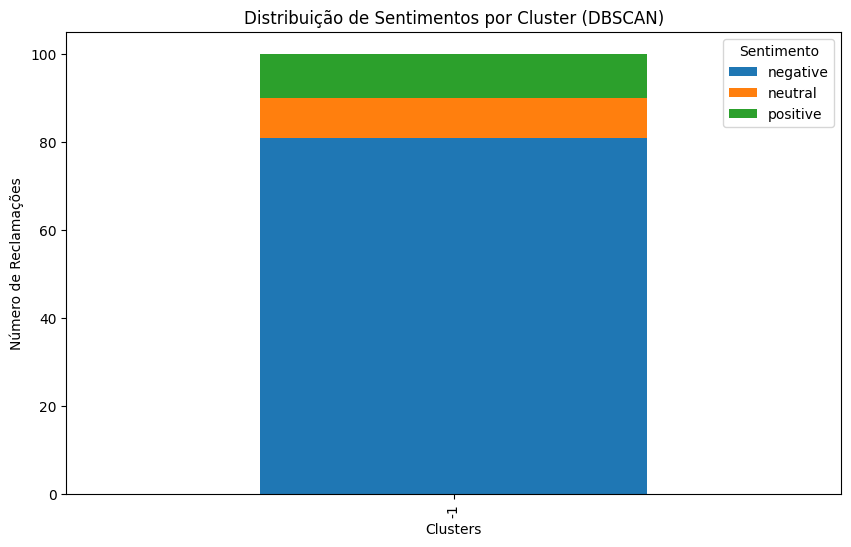

In [76]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Reduzir dimensionalidade com PCA antes do DBSCAN
pca = PCA(n_components=10)  # Reduzir para 10 dimensões
embeddings_reduced = pca.fit_transform(embeddings_scaled)

# Aplicar DBSCAN com parâmetros ajustados
dbscan = DBSCAN(eps=1.0, min_samples=5)  # Ajuste eps para testar
dados_limpos['dbscan_cluster'] = dbscan.fit_predict(embeddings_reduced)

# Verificar clusters formados
print("Clusters identificados pelo DBSCAN:")
print(dados_limpos['dbscan_cluster'].value_counts())

# Relacionar clusters com sentimentos
cluster_sentimentos = dados_limpos.groupby(['dbscan_cluster', 'sentimento']).size().unstack(fill_value=0)
print(cluster_sentimentos)

# Visualizar a relação em gráfico de barras
cluster_sentimentos.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Distribuição de Sentimentos por Cluster (DBSCAN)")
plt.ylabel("Número de Reclamações")
plt.xlabel("Clusters")
plt.legend(title="Sentimento")
plt.show()


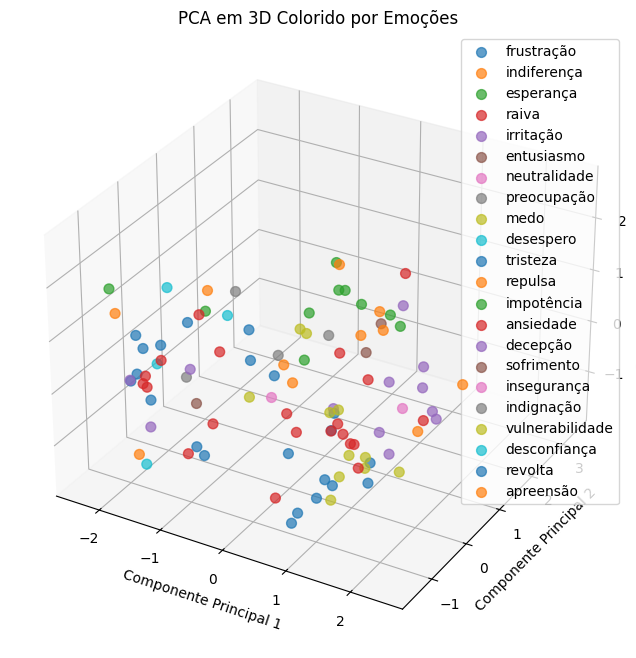

In [77]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduzir dimensionalidade com PCA
pca = PCA(n_components=3)  # Reduzir para 3 dimensões
embeddings_3d = pca.fit_transform(embeddings)

# Adicionar as dimensões reduzidas ao DataFrame
dados_limpos['pca_x'] = embeddings_3d[:, 0]
dados_limpos['pca_y'] = embeddings_3d[:, 1]
dados_limpos['pca_z'] = embeddings_3d[:, 2]

# Plotar em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar por cada emoção para colorir os dados
for emocao in dados_limpos['emocao'].unique():
    subset = dados_limpos[dados_limpos['emocao'] == emocao]
    ax.scatter(subset['pca_x'], subset['pca_y'], subset['pca_z'], label=emocao, alpha=0.7, s=50)

# Adicionar rótulos e título
ax.set_title("PCA em 3D Colorido por Emoções")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduzir dimensionalidade com PCA
pca = PCA(n_components=3)  # Reduzir para 3 dimensões
embeddings_3d = pca.fit_transform(embeddings)

# Adicionar as dimensões reduzidas ao DataFrame
dados_limpos['pca_x'] = embeddings_3d[:, 0]
dados_limpos['pca_y'] = embeddings_3d[:, 1]
dados_limpos['pca_z'] = embeddings_3d[:, 2]

# Plotar em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar por cada emoção para colorir os dados
for emocao in dados_limpos['sentimento'].unique():
    subset = dados_limpos[dados_limpos['sentimento'] == emocao]
    ax.scatter(subset['pca_x'], subset['pca_y'], subset['pca_z'], label=emocao, alpha=0.7, s=50)

# Adicionar rótulos e título
ax.set_title("PCA em 3D Colorido por Emoções")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.show()


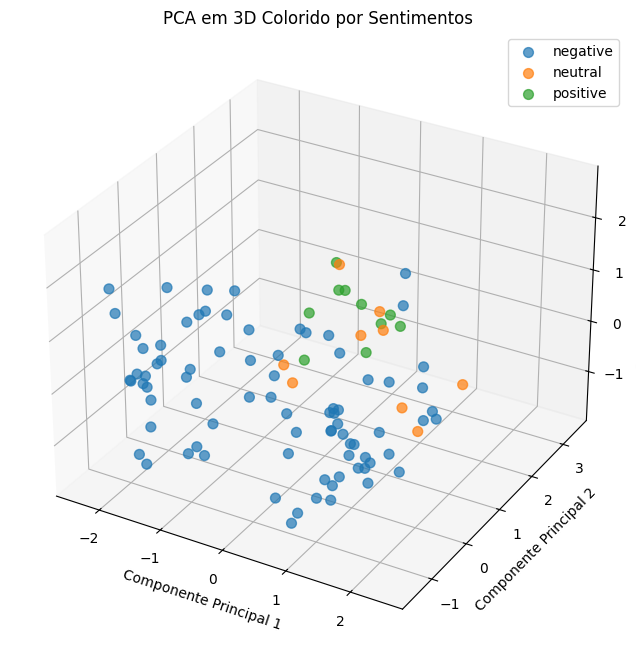

In [78]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduzir dimensionalidade com PCA
pca = PCA(n_components=3)  # Reduzir para 3 dimensões
embeddings_3d = pca.fit_transform(embeddings)

# Adicionar as dimensões reduzidas ao DataFrame
dados_limpos['pca_x'] = embeddings_3d[:, 0]
dados_limpos['pca_y'] = embeddings_3d[:, 1]
dados_limpos['pca_z'] = embeddings_3d[:, 2]

# Plotar em 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Iterar por cada sentimento para colorir os dados
for sentimento in dados_limpos['sentimento'].unique():
    subset = dados_limpos[dados_limpos['sentimento'] == sentimento]
    ax.scatter(subset['pca_x'], subset['pca_y'], subset['pca_z'], label=sentimento, alpha=0.7, s=50)

# Adicionar rótulos e título
ax.set_title("PCA em 3D Colorido por Sentimentos")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
ax.legend()
plt.show()


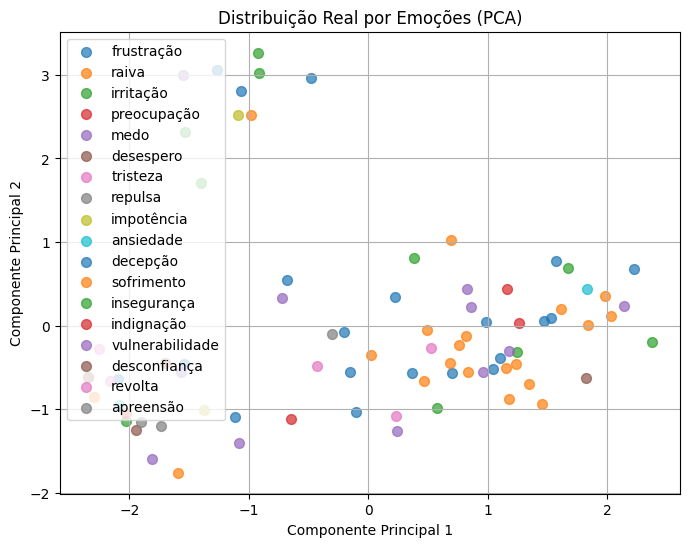

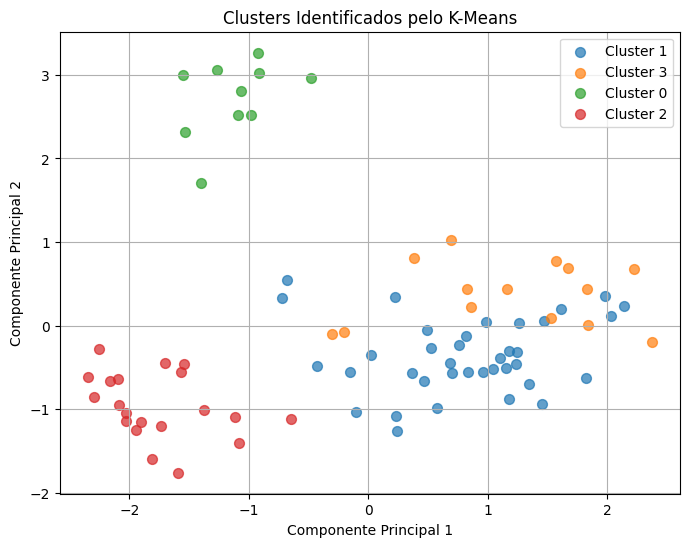

In [84]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Filtrar reclamações com sentimento negativo
dados_negativos = dados_limpos[dados_limpos['sentimento'] == 'negative'].reset_index(drop=True)

# 2. Gerar embeddings correspondentes
embeddings_negativos = embeddings[dados_negativos.index]

# 3. Reduzir dimensionalidade com PCA
pca = PCA(n_components=2)  # Reduzir para 2 dimensões
embeddings_negativos_2d = pca.fit_transform(embeddings_negativos)

# 4. Aplicar K-Means para agrupar as emoções
n_clusters = 4  # Ajuste conforme necessário
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
dados_negativos.loc[:, 'cluster_emocao'] = kmeans.fit_predict(embeddings_negativos)

# 5. Visualizar os clusters reais baseados em emoções
plt.figure(figsize=(8, 6))
for emocao in dados_negativos['emocao'].unique():
    subset = dados_negativos[dados_negativos['emocao'] == emocao]
    plt.scatter(embeddings_negativos_2d[subset.index, 0],
                embeddings_negativos_2d[subset.index, 1],
                label=emocao, alpha=0.7, s=50)
plt.legend()
plt.title("Distribuição Real por Emoções (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()

# 6. Visualizar os clusters atribuídos pelo K-Means
plt.figure(figsize=(8, 6))
for cluster in dados_negativos['cluster_emocao'].unique():
    subset = dados_negativos[dados_negativos['cluster_emocao'] == cluster]
    plt.scatter(embeddings_negativos_2d[subset.index, 0],
                embeddings_negativos_2d[subset.index, 1],
                label=f"Cluster {cluster}", alpha=0.7, s=50)
plt.legend()
plt.title("Clusters Identificados pelo K-Means")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


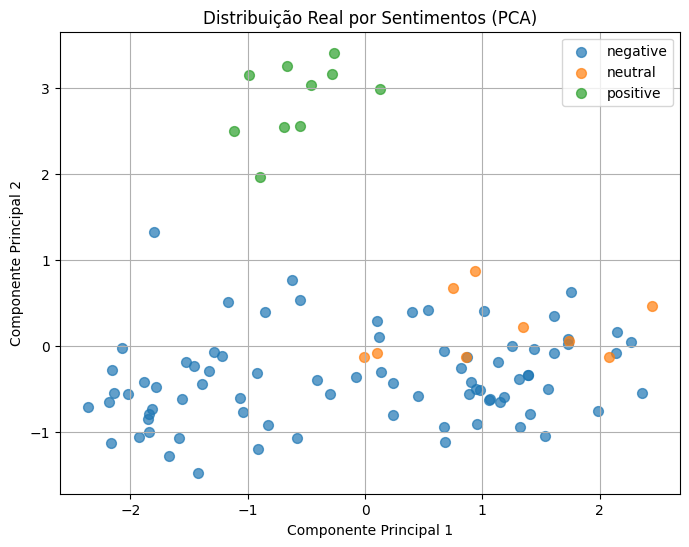

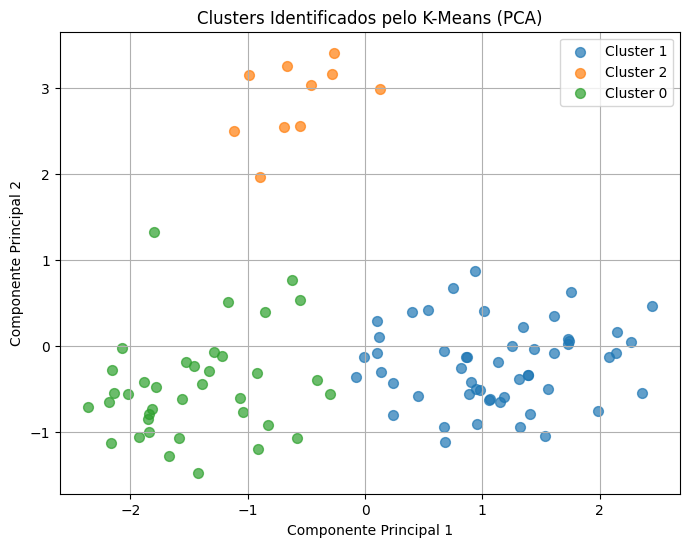

In [85]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Reduzir dimensionalidade com PCA
pca = PCA(n_components=2)  # Reduzir para 2 dimensões
embeddings_2d = pca.fit_transform(embeddings)

# Adicionar as dimensões reduzidas ao DataFrame
dados_limpos['pca_x'] = embeddings_2d[:, 0]
dados_limpos['pca_y'] = embeddings_2d[:, 1]

# 2. Aplicar K-Means para agrupar os sentimentos
n_clusters = 3  # Ajustar conforme necessário (positivo, neutro, negativo)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
dados_limpos.loc[:, 'cluster_sentimento'] = kmeans.fit_predict(embeddings)

# 3. Visualizar os clusters reais baseados nos sentimentos
plt.figure(figsize=(8, 6))
for sentimento in dados_limpos['sentimento'].unique():
    subset = dados_limpos[dados_limpos['sentimento'] == sentimento]
    plt.scatter(subset['pca_x'], subset['pca_y'], label=sentimento, alpha=0.7, s=50)
plt.legend()
plt.title("Distribuição Real por Sentimentos (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()

# 4. Visualizar os clusters atribuídos pelo K-Means
plt.figure(figsize=(8, 6))
for cluster in dados_limpos['cluster_sentimento'].unique():
    subset = dados_limpos[dados_limpos['cluster_sentimento'] == cluster]
    plt.scatter(subset['pca_x'], subset['pca_y'], label=f"Cluster {cluster}", alpha=0.7, s=50)
plt.legend()
plt.title("Clusters Identificados pelo K-Means (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid()
plt.show()


In [ ]:
s